# Imports

In [1]:
import pandas as pd
import pickle
import pywt, math
import statsmodels.api as sm
import os
from tensorflow.keras.models import save_model
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import load_model
import numpy as np
from sklearn.linear_model import ElasticNet
from tensorflow.keras.layers import Dropout
from kerastuner.tuners import BayesianOptimization
import random
import matplotlib.pyplot as plt
import datetime
from tensorflow.keras import regularizers
from pandas.plotting import lag_plot
from datetime import datetime
from sklearn import linear_model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LayerNormalization
from sklearn.metrics import r2_score
import time
from tensorflow.keras.utils import plot_model
from keras.regularizers import l1, l2
from tensorflow.keras.regularizers import l1_l2
from datetime import timedelta
from scipy.spatial import KDTree
from sklearn.linear_model import LinearRegression
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
from keras.models import load_model
from IPython.display import Image
import keras_tuner as kt
from keras_tuner import RandomSearch
from keras.models import load_model
from sklearn.metrics import mean_squared_error
import scipy.io
from sklearn.model_selection import TimeSeriesSplit

C:\Users\VANKK\AppData\Local\Temp\ipykernel_12396\644169225.py:12: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import BayesianOptimization


# Import data

In [2]:
path = "USD_CHF_RV_89_93.csv.zip"
df = pd.read_csv(f'{path}', compression = 'zip') 
rv = df.rvfx.values
r = np.flip(rv - np.mean(rv)) # Flip the data for convenience
test_size = 520
r_test = np.flip(r[:test_size]) # This corresponds to the last 520 observation (The most recent ones)
r = np.append(r, 0)
ts = np.arange(0, len(r))

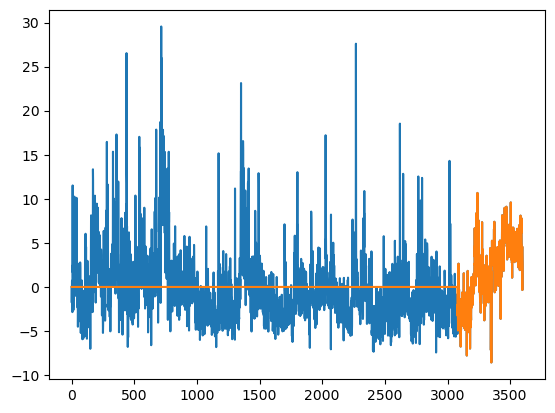

In [3]:
plt.plot(np.flip(r))
plt.plot(np.concatenate((np.zeros((len(r)-test_size),),r_test)))

In [4]:
def comparison_test_set(original_series,horizon):

    original_series = original_series[:-1]
    compare = np.zeros((len(original_series) - horizon + 1,))

    for i in range(len(compare)):

        compare[i] = np.mean(original_series[i:i+horizon])

    return np.flip(compare)[-test_size+horizon:]

# DWT

In [5]:
c = 1/2
dec_lo, dec_hi, rec_lo, rec_hi = [c, c], [-c, c], [1, 1], [1, -1]
filter_bank = [dec_lo, dec_hi, rec_lo, rec_hi]
BandiWavelet = pywt.Wavelet(name="Bandi", filter_bank=filter_bank)

In [6]:
(A1, D1) = pywt.dwt(r, BandiWavelet)
(A2, D2) = pywt.dwt(A1, BandiWavelet)

# Creating the timestamps to making indexing more convenient
ts1 = np.arange(0, len(r), 2**1)
ts2 = np.arange(0, len(r), 2**2)

In [7]:
def bring_to_original_size(arr, j):

  # This function accepts the wavelet coefficients and depending on the scale
  # will return the wavelet coefficients that are of the same size as the
  # original realized volatility time series (3600), by filling zeros in between.

  output = np.array([])

  zeros_array = np.zeros(2**j-1)

  for i in range(len(arr)):

    output = np.append(output, arr[i])

    output = np.concatenate((output, zeros_array))

  return output

def adjust_size(A,D):

  # Since we model the scales using the other scales, for the j=3 coefficients
  # last 7 observations are 0s, for j=2 its 3 and for j=1 its 1. Hence the output
  # is the matrix of wavelet coefficients being all of the size of the coefficients
  # for j=3. Check the output.

  lengths = []

  for i in range(A.shape[1]):

      lengths.append(np.where(A[:,i] == A[:,i][A[:,i] != 0][-1])[0][0]+1)

  cutoff = np.min(lengths)

  A_output = A[:cutoff,:]
  D_output = D[:cutoff,:]

  return A_output, D_output

fA1 = bring_to_original_size(A1, 1)
fA2 = bring_to_original_size(A2, 2)
fD1 = bring_to_original_size(D1, 1)
fD2 = bring_to_original_size(D2, 2)

fA = np.column_stack((fA1,fA2))
fD = np.column_stack((fD1,fD2))
fA, fD = adjust_size(fA,fD)

# Creating the timestamps to making indexing more convenient
ts1 = np.arange(0, len(fA), 2**1)
ts2 = np.arange(0, len(fA), 2**2)

In [8]:
# Assembling function
def assemble(position, yA2, yD2, yD1):

    a2 = yA2

    if position == 3:

        d2 = -yD2
        d1 = -yD1

    elif position == 2:
        d2 = -yD2
        d1 = yD1

    elif position == 1:
        d2 = yD2
        d1 = -yD1

    elif position == 0:
        d2 = yD2
        d1 = yD1

    output = a2 + d2 + d1

    return output

# Data Preprocessing Functions

In [9]:
def check_1(ind_mat):
    checker = 0
    for i in range(len(ind_mat)):
        if np.sum(ind_mat[i,0] < ind_mat[i,1:]) != len(ind_mat[i,1:]):
            print(f"Check observation {i}")
            print(f"Row is {ind_mat[i,:]}")
            print('                          ')
        else:
            checker += 1
    return checker == len(ind_mat)

def check_2(ind_mat):
    checker = 0
    for i in range(len(ind_mat)):
        row = ind_mat[i,:]
        y = row[0]
        x = row[1:]
        check = 0
        for j in range(len(x)):
            if x[j] > y:
                check += 1
        if check == len(x):
            checker += 1
        else:
            print(f'Something is wrong with the order, check row {i}')
            print(f'{row}')
            print(f'           ')
    return checker == len(ind_mat)

In [10]:
def adj(M, j, struct, num_lags):

    num_lags = np.array(num_lags).astype(int)

    lags = [np.arange(struct[0],struct[0]+num_lags[0]),np.arange(struct[1],struct[1]+num_lags[1])]

    Jmax = num_lags[0]+num_lags[1]

    max_inds = [-2*(num_lags[0]+struct[0]-1)-1, -4*(num_lags[1]+struct[1]-1)-1]
    idxcount = len(M) + np.min(max_inds)

    if j == 2:
        idx = ts2[ts2 < idxcount][-1]
    elif j == 1:
        idx = ts1[ts1 < idxcount][-1]

    y_idx = np.arange(0,idx+1,2**j)

    X = np.zeros((len(y_idx),Jmax))
    X_ind = np.zeros((len(y_idx),Jmax))

    X_indices = {1:np.arange(0,num_lags[0]),2:np.arange(num_lags[0],num_lags[0]+num_lags[1])}

    for k in range(M.shape[1]):

        X_idx = np.nonzero(fA[:,k])[0]

        indices = np.zeros((len(y_idx),num_lags[k]), dtype=int)

        for i in range(len(y_idx)):

            current_y_idx = y_idx[i]

            try:

                x_idx = X_idx[X_idx > current_y_idx][lags[k]]

            except:

                print('Something is wrong')

            indices[i,:] = x_idx

        X[:,X_indices[k+1]] = M[indices,k]
        X_ind[:,X_indices[k+1]] = indices

    y = M[y_idx,j-1]
    reg_mat = np.column_stack((y,X))
    reg_mat_ind = np.column_stack((y_idx,X_ind))

    # Do the checks to see if data is in the right order/format
    # print("Check. Checking if the index of y is always smaller than the indices of any feature included, status = ",check_1(reg_mat_ind),check_2(reg_mat_ind))
#     print("                   ")
    return reg_mat

In [11]:
def generate_data(num_lags_dict, fA = fA, fD = fD):

    Reg_data_dict = {}

    lags = [0,0,0]
    num_lags = num_lags_dict[1]
    a_reg_mat, d_reg_mat = adj(fA, 1, lags, num_lags), adj(fD, 1, lags, num_lags)
    reg_mat = {"A":a_reg_mat, "D":d_reg_mat}
    Reg_data_dict[1] = reg_mat

    lags = [0,0,0]
    num_lags = num_lags_dict[2]
    a_reg_mat, d_reg_mat = adj(fA, 2, lags, num_lags), adj(fD, 2, lags, num_lags)
    reg_mat = {"A":a_reg_mat, "D":d_reg_mat}
    Reg_data_dict[2] = reg_mat

    lags = [1,0,0]
    num_lags = num_lags_dict[3]
    a_reg_mat, d_reg_mat = adj(fA, 2, lags, num_lags), adj(fD, 2, lags, num_lags)
    reg_mat = {"A":a_reg_mat, "D":d_reg_mat}
    Reg_data_dict[3] = reg_mat

    return Reg_data_dict

# Multistep Linear Model

## Decimation prediction function

In [12]:
def dmfndlm(adjusting_models, num_lags_dict, batch_size, val_size = len(r_test)):

    # Out-of-sample predictions

    lm_predictions = []

    update_counter = 0
    iteration = 1

    test_size_decrease = np.copy(val_size)

    lm_save_path = f'multistep_lm/batch_size_{batch_size}/adjusting_models_{iteration}.pkl'

    os.makedirs(os.path.dirname(lm_save_path), exist_ok=True)

    with open(lm_save_path, 'wb') as file:
        pickle.dump(adjusting_models, file)

    for k in range(val_size,0,-1):

        T = k                              # Current day
        t = T-1                            # Next day (The one we make the prediction for)

        stop2 = ts2[ts2 <= t][-1]          # The index for the wavelet (j=2) that is needed for the reconstruction
        stop1 = ts1[ts1 <= t][-1]

        reconstruct_from = [stop1, stop2] # Wavelet indices (that correspond to the original rv timeseries)

        position = t - reconstruct_from[-1] # 0 to 7 (The position explained in the thesis)

        if position == 3 or position == 2:

            model1a,model1d = adjusting_models[1]['A'],adjusting_models[1]['D']
            model2a,model2d = adjusting_models[3]['A'],adjusting_models[3]['D']

            idx_2a = [np.arange(0,num_lags_dict[5][3][0]),np.arange(0,num_lags_dict[5][3][1])]
            idx_2d = [np.arange(0,num_lags_dict[6][3][0]),np.arange(0,num_lags_dict[6][3][1])]
            idx_1a = [np.arange(0,num_lags_dict[1][1][0]),np.arange(0,num_lags_dict[1][1][1])]
            idx_1d = [np.arange(0,num_lags_dict[2][1][0]),np.arange(0,num_lags_dict[2][1][1])]

        elif position == 1 or position == 0:

            model1a,model1d = adjusting_models[1]['A'],adjusting_models[1]['D']
            model2a,model2d = adjusting_models[2]['A'],adjusting_models[2]['D']

            idx_2a = [np.arange(0,num_lags_dict[3][2][0]),np.arange(0,num_lags_dict[3][2][1])]
            idx_2d = [np.arange(0,num_lags_dict[4][2][0]),np.arange(0,num_lags_dict[4][2][1])]
            idx_1a = [np.arange(0,num_lags_dict[1][1][0]),np.arange(0,num_lags_dict[1][1][1])]
            idx_1d = [np.arange(0,num_lags_dict[2][1][0]),np.arange(0,num_lags_dict[2][1][1])]

        start2a = [ts1[ts1 >= T][idx_2a[0]], ts2[ts2 >= T][idx_2a[1]]]
        start2d = [ts1[ts1 >= T][idx_2d[0]], ts2[ts2 >= T][idx_2d[1]]]
        start1a = [ts1[ts1 >= T][idx_1a[0]], ts2[ts2 >= T][idx_1a[1]]]
        start1d = [ts1[ts1 >= T][idx_1d[0]], ts2[ts2 >= T][idx_1d[1]]]

        X_2a = np.concatenate((fA[start2a[0],0],fA[start2a[1],1],fD[start2a[0],0],fD[start2a[1],1])).reshape(1, -1)
        X_2d = np.concatenate((fA[start2d[0],0],fA[start2d[1],1],fD[start2d[0],0],fD[start2d[1],1])).reshape(1, -1)
        X_1a = np.concatenate((fA[start1a[0],0],fA[start1a[1],1],fD[start1a[0],0],fD[start1a[1],1])).reshape(1, -1)
        X_1d = np.concatenate((fA[start1d[0],0],fA[start1d[1],1],fD[start1d[0],0],fD[start1d[1],1])).reshape(1, -1)

        yA2 = model2a.predict(X_2a)
        yD2 = model2d.predict(X_2d)
        yD1 = model1d.predict(X_1d)

        pred = assemble(position, yA2, yD2, yD1)[0]

        lm_predictions.append(pred)

        update_counter += 1

        if update_counter % batch_size == 0:
            
            test_size_decrease = test_size_decrease - batch_size
            adjusting_models, num_lags_dict_big = gen_data_for_lm(num_lags_dict, test_size_decrease)

            iteration += 1

            lm_save_path = f'multistep_lm/batch_size_{batch_size}/adjusting_models_{iteration}.pkl'

            os.makedirs(os.path.dirname(lm_save_path), exist_ok=True)

            with open(lm_save_path, 'wb') as file:
                pickle.dump(adjusting_models, file)

    return lm_predictions

## No decimation approach

In [27]:
def mfndlm(adjusting_models, num_lags_dict, batch_size, val_size = len(r_test)):

    # Out-of-sample predictions

    lm_predictions = []

    update_counter = 0

    test_size_decrease = np.copy(val_size)

    iteration = 1

    lm_save_path = f'multistep_lm/batch_size_{batch_size}/no_decimation_adjusting_models_{iteration}.pkl'

    os.makedirs(os.path.dirname(lm_save_path), exist_ok=True)

    with open(lm_save_path, 'wb') as file:
        pickle.dump(adjusting_models, file)

    for k in range(val_size,0,-1):

        T = k                              # Current day
        t = T-1                            # Next day (The one we make the prediction for)

        stop2 = ts2[ts2 <= t][-1]          # The index for the wavelet (j=2) that is needed for the reconstruction
        stop1 = ts1[ts1 <= t][-1]

        reconstruct_from = [stop1, stop2] # Wavelet indices (that correspond to the original rv timeseries)

        position = t - reconstruct_from[-1] # 0 to 7 (The position explained in the thesis)

        model1a,model1d = adjusting_models[1]['A'],adjusting_models[1]['D']
        model2a,model2d = adjusting_models[2]['A'],adjusting_models[2]['D']

        idx_2a = [np.arange(0,num_lags_dict[3][2][0]),np.arange(0,num_lags_dict[3][2][1])]
        idx_2d = [np.arange(0,num_lags_dict[4][2][0]),np.arange(0,num_lags_dict[4][2][1])]
        idx_1a = [np.arange(0,num_lags_dict[1][1][0]),np.arange(0,num_lags_dict[1][1][1])]
        idx_1d = [np.arange(0,num_lags_dict[2][1][0]),np.arange(0,num_lags_dict[2][1][1])]

        start2a = [ts1[ts1 >= T][idx_2a[0]], ts2[ts2 >= T][idx_2a[1]]]
        start2d = [ts1[ts1 >= T][idx_2d[0]], ts2[ts2 >= T][idx_2d[1]]]
        start1a = [ts1[ts1 >= T][idx_1a[0]], ts2[ts2 >= T][idx_1a[1]]]
        start1d = [ts1[ts1 >= T][idx_1d[0]], ts2[ts2 >= T][idx_1d[1]]]

        X_2a = np.concatenate((fA[start2a[0],0],fA[start2a[1],1],fD[start2a[0],0],fD[start2a[1],1])).reshape(1, -1)
        X_2d = np.concatenate((fA[start2d[0],0],fA[start2d[1],1],fD[start2d[0],0],fD[start2d[1],1])).reshape(1, -1)
        X_1a = np.concatenate((fA[start1a[0],0],fA[start1a[1],1],fD[start1a[0],0],fD[start1a[1],1])).reshape(1, -1)
        X_1d = np.concatenate((fA[start1d[0],0],fA[start1d[1],1],fD[start1d[0],0],fD[start1d[1],1])).reshape(1, -1)

        yA2 = model2a.predict(X_2a)
        yD2 = model2d.predict(X_2d)
        yD1 = model1d.predict(X_1d)

        pred = assemble(position, yA2, yD2, yD1)[0]

        lm_predictions.append(pred)

        update_counter += 1

        if update_counter % batch_size == 0:

            test_size_decrease = test_size_decrease - batch_size

            adjusting_models, num_lags_dict_big = gen_data_for_lm(num_lags_dict, test_size_decrease)

            iteration += 1

            lm_save_path = f'multistep_lm/batch_size_{batch_size}/no_decimation_adjusting_models_{iteration}.pkl'

            os.makedirs(os.path.dirname(lm_save_path), exist_ok=True)

            with open(lm_save_path, 'wb') as file:
                pickle.dump(adjusting_models, file)

    return lm_predictions

## Ridge/Lasso tuning

In [14]:
def ridge_tune(X,y):

    grid = np.arange(0,2,0.1)

    cv_performance = []

    test_size = int(0.2*len(y))

    tscv = TimeSeriesSplit(n_splits=4, test_size=test_size)

    for k in range(len(grid)):

        param = grid[k]
        avg_mse = []

        for i, (train_index, test_index) in enumerate(tscv.split(X)):

            X_train, y_train = np.flip(X,0)[train_index,:], np.flip(y)[train_index]
            X_val, y_val = np.flip(X,0)[test_index,:], np.flip(y)[test_index]

            if param != 0:
                model = linear_model.Ridge(alpha=param)
                model = model.fit(X_train, y_train)
            else:
                model = LinearRegression().fit(X_train, y_train)

            preds = model.predict(X_val)

            avg_mse.append(mean_squared_error(y_val, preds))

        cv_performance.append(np.mean(avg_mse))

    best_alpha = grid[np.where(cv_performance == np.min(cv_performance))[0][0]]

    return best_alpha

In [15]:
def prep_lm_models(i, scale, coef, Reg_data_dict, val_size = len(r_test)):

    ya = Reg_data_dict[i]['A'][:,0]
    Xa = Reg_data_dict[i]['A'][:,1:]
    yd = Reg_data_dict[i]['D'][:,0]
    Xd = Reg_data_dict[i]['D'][:,1:]

    if scale == 1:
        idx = int(len(ya) - (val_size)/(2**1)) 
    elif scale == 2:
        idx = int(len(ya) - (val_size)/(2**2))

    ya_train, ya_test = ya[-idx:], ya[:-idx]
    yd_train, yd_test = yd[-idx:], yd[:-idx]
    Xa_train, Xa_test = Xa[-idx:,:], Xa[:-idx,:]
    Xd_train, Xd_test = Xd[-idx:,:], Xd[:-idx,:]

    X_train = np.column_stack((Xa_train, Xd_train))
    X_test = np.column_stack((Xa_test, Xd_test))

    if coef == 'A':
        alpha = ridge_tune(X_train, ya_train)

        if alpha != 0:
            # model = linear_model.Lasso(alpha=alpha)
            model = linear_model.Ridge(alpha=alpha)
            model = model.fit(X_train, ya_train)
        else:
            model = LinearRegression().fit(X_train, ya_train)
    else:
        alpha = ridge_tune(X_train, yd_train)
        if alpha != 0:
            # model = linear_model.Lasso(alpha=alpha)
            model = linear_model.Ridge(alpha=alpha)
            model = model.fit(X_train, yd_train)
        else:
            model = LinearRegression().fit(X_train, yd_train)

    return model

In [16]:
def gen_data_for_lm(lags, val_size = len(r_test)):

    # Get model1a
    Reg_data_dict = generate_data(lags[1])
    model1a = prep_lm_models(1, 1, "A", Reg_data_dict, val_size)

    # Get model1d
    Reg_data_dict = generate_data(lags[2])
    model1d = prep_lm_models(1, 1, "D", Reg_data_dict, val_size)

    # Get model2a
    Reg_data_dict = generate_data(lags[3])
    model2a = prep_lm_models(2, 2, "A", Reg_data_dict, val_size)

    # Get model2d
    Reg_data_dict = generate_data(lags[4])
    model2d = prep_lm_models(2, 2, "D", Reg_data_dict, val_size)

    # Get model3a
    Reg_data_dict = generate_data(lags[5])
    model3a = prep_lm_models(3, 2, "A", Reg_data_dict, val_size)

    # Get model3d
    Reg_data_dict = generate_data(lags[6])
    model3d = prep_lm_models(3, 2, "D", Reg_data_dict, val_size)

    adjusting_models = {1:{"A":model1a,"D":model1d},2:{"A":model2a,"D":model2d},3:{"A":model3a,"D":model3d}}
    num_lags_dict_big = {1:lags[1],2:lags[2],3:lags[3],4:lags[4],5:lags[5],6:lags[6]}

    return adjusting_models, num_lags_dict_big

In [18]:
multistep_lags_path = 'multistep_best_lags_lm_USDCHF.pkl'
with open(multistep_lags_path, 'rb') as file:
    best_lags = pickle.load(file)

adjusting_models, num_lags_dict_big = gen_data_for_lm(best_lags)

In [19]:
batch_size = 22

In [33]:
# 1 day ahead forecast
batch_size = 22
multistep_lm = dmfndlm(adjusting_models, num_lags_dict_big, batch_size)
print("MSE = ", mean_squared_error(multistep_lm, r_test))
print("MAE = ", mean_absolute_error(multistep_lm, r_test))
print("R^2 is = ",r2_score(r_test, multistep_lm))

MSE =  4.8039593987351
MAE =  1.3031756132633319
R^2 is =  0.676807062635157


In [64]:
# 1 day ahead forecast
batch_size = 22
multistep_lm = mfndlm(adjusting_models, num_lags_dict_big, batch_size)
print("MSE = ", mean_squared_error(multistep_lm, r_test))
print("MAE = ", mean_absolute_error(multistep_lm, r_test))
print("R^2 is = ",r2_score(r_test, multistep_lm))

MSE =  4.858782720192742
MAE =  1.3251060132529144
R^2 is =  0.673118748720044


In [27]:
def faster_dmfndlm(adjusting_models, num_lags_dict, batch_size, val_size = len(r_test)):

    # Out-of-sample predictions

    lm_predictions = []

    update_counter = 0
    iteration = 1

    lm_save_path = f'multistep_lm/batch_size_{batch_size}/adjusting_models_{iteration}.pkl'

    with open(lm_save_path, 'rb') as file:
        adjusting_models = pickle.load(file)

    for k in range(val_size,0,-1):

        T = k                              # Current day
        t = T-1                            # Next day (The one we make the prediction for)

        stop2 = ts2[ts2 <= t][-1]          # The index for the wavelet (j=2) that is needed for the reconstruction
        stop1 = ts1[ts1 <= t][-1]

        reconstruct_from = [stop1, stop2] # Wavelet indices (that correspond to the original rv timeseries)

        position = t - reconstruct_from[-1] # 0 to 7 (The position explained in the thesis)

        if position == 3 or position == 2:

            model1a,model1d = adjusting_models[1]['A'],adjusting_models[1]['D']
            model2a,model2d = adjusting_models[3]['A'],adjusting_models[3]['D']

            idx_2a = [np.arange(0,num_lags_dict[5][3][0]),np.arange(0,num_lags_dict[5][3][1])]
            idx_2d = [np.arange(0,num_lags_dict[6][3][0]),np.arange(0,num_lags_dict[6][3][1])]
            idx_1a = [np.arange(0,num_lags_dict[1][1][0]),np.arange(0,num_lags_dict[1][1][1])]
            idx_1d = [np.arange(0,num_lags_dict[2][1][0]),np.arange(0,num_lags_dict[2][1][1])]

        elif position == 1 or position == 0:

            model1a,model1d = adjusting_models[1]['A'],adjusting_models[1]['D']
            model2a,model2d = adjusting_models[2]['A'],adjusting_models[2]['D']

            idx_2a = [np.arange(0,num_lags_dict[3][2][0]),np.arange(0,num_lags_dict[3][2][1])]
            idx_2d = [np.arange(0,num_lags_dict[4][2][0]),np.arange(0,num_lags_dict[4][2][1])]
            idx_1a = [np.arange(0,num_lags_dict[1][1][0]),np.arange(0,num_lags_dict[1][1][1])]
            idx_1d = [np.arange(0,num_lags_dict[2][1][0]),np.arange(0,num_lags_dict[2][1][1])]

        start2a = [ts1[ts1 >= T][idx_2a[0]], ts2[ts2 >= T][idx_2a[1]]]
        start2d = [ts1[ts1 >= T][idx_2d[0]], ts2[ts2 >= T][idx_2d[1]]]
        start1a = [ts1[ts1 >= T][idx_1a[0]], ts2[ts2 >= T][idx_1a[1]]]
        start1d = [ts1[ts1 >= T][idx_1d[0]], ts2[ts2 >= T][idx_1d[1]]]

        X_2a = np.concatenate((fA[start2a[0],0],fA[start2a[1],1],fD[start2a[0],0],fD[start2a[1],1])).reshape(1, -1)
        X_2d = np.concatenate((fA[start2d[0],0],fA[start2d[1],1],fD[start2d[0],0],fD[start2d[1],1])).reshape(1, -1)
        X_1a = np.concatenate((fA[start1a[0],0],fA[start1a[1],1],fD[start1a[0],0],fD[start1a[1],1])).reshape(1, -1)
        X_1d = np.concatenate((fA[start1d[0],0],fA[start1d[1],1],fD[start1d[0],0],fD[start1d[1],1])).reshape(1, -1)

        yA2 = model2a.predict(X_2a)
        yD2 = model2d.predict(X_2d)
        yD1 = model1d.predict(X_1d)

        pred = assemble(position, yA2, yD2, yD1)[0]

        lm_predictions.append(pred)

        update_counter += 1

        if update_counter % batch_size == 0:

            iteration += 1
            
            lm_save_path = f'multistep_lm/batch_size_{batch_size}/adjusting_models_{iteration}.pkl'

            with open(lm_save_path, 'rb') as file:
                adjusting_models = pickle.load(file)

    return lm_predictions

In [28]:
multistep_lm = faster_dmfndlm(1, num_lags_dict_big, batch_size)
print("MSE = ", mean_squared_error(multistep_lm, r_test))
print("MAE = ", mean_absolute_error(multistep_lm, r_test))
print("R^2 is = ",r2_score(r_test, multistep_lm))

# lm_save_path = f'prediction/decimation_multistep_lm_{1}.pkl'
# os.makedirs(os.path.dirname(lm_save_path), exist_ok=True)
# with open(lm_save_path, 'wb') as file:
#     pickle.dump(multistep_lm, file)

MSE =  4.8039593987351
MAE =  1.3031756132633319


NameError: name 'r2score' is not defined

## H steps ahead

### Decimation

In [20]:
def dmhflm(t, T, info, adjusting_models, num_lags_dict):

    u_fA = info[2]
    u_fD = info[3]

    # Out-of-sample predictions

    stop2 = ts2[ts2 <= t][-1]          # The index for the wavelet (j=2) that is needed for the reconstruction
    stop1 = ts1[ts1 <= t][-1]

    reconstruct_from = [stop1, stop2] # Wavelet indices (that correspond to the original rv timeseries)

    check = [0,0] # Check variable records whether information is already available from previous forecasts or not, if 1 then the prediction for that scale doesnt have to be performed.

    if info[0][0] != None:
        if stop1 >= info[0][0]:
            check[0] = 1

    if info[1][0] != None:
        if stop2 >= info[1][0]:
            check[1] = 1

    position = t - reconstruct_from[-1] # 0 to 7 (The position explained in the thesis)

    if position == 3 or position == 2:

        model1a,model1d = adjusting_models[1]['A'],adjusting_models[1]['D']
        model2a,model2d = adjusting_models[3]['A'],adjusting_models[3]['D']

        idx_2a = [np.arange(0,num_lags_dict[5][3][0]),np.arange(0,num_lags_dict[5][3][1])]
        idx_2d = [np.arange(0,num_lags_dict[6][3][0]),np.arange(0,num_lags_dict[6][3][1])]
        idx_1a = [np.arange(0,num_lags_dict[1][1][0]),np.arange(0,num_lags_dict[1][1][1])]
        idx_1d = [np.arange(0,num_lags_dict[2][1][0]),np.arange(0,num_lags_dict[2][1][1])]

    elif position == 1 or position == 0:

        model1a,model1d = adjusting_models[1]['A'],adjusting_models[1]['D']
        model2a,model2d = adjusting_models[2]['A'],adjusting_models[2]['D']

        idx_2a = [np.arange(0,num_lags_dict[3][2][0]),np.arange(0,num_lags_dict[3][2][1])]
        idx_2d = [np.arange(0,num_lags_dict[4][2][0]),np.arange(0,num_lags_dict[4][2][1])]
        idx_1a = [np.arange(0,num_lags_dict[1][1][0]),np.arange(0,num_lags_dict[1][1][1])]
        idx_1d = [np.arange(0,num_lags_dict[2][1][0]),np.arange(0,num_lags_dict[2][1][1])]

    if check[0] == 0: # The prediction has to be made as info is available

        start1a = [ts1[ts1 >= T][idx_1a[0]], ts2[ts2 >= T][idx_1a[1]]]
        start1d = [ts1[ts1 >= T][idx_1d[0]], ts2[ts2 >= T][idx_1d[1]]]

        X_1a = np.concatenate((u_fA[start1a[0],0],u_fA[start1a[1],1],u_fD[start1a[0],0],u_fD[start1a[1],1])).reshape(1, -1)
        X_1d = np.concatenate((u_fA[start1d[0],0],u_fA[start1d[1],1],u_fD[start1d[0],0],u_fD[start1d[1],1])).reshape(1, -1)
        yA1 = model1a.predict(X_1a)[0]
        yD1 = model1d.predict(X_1d)[0]

    else:
        yA1, yD1 = info[0][1]

    if check[1] == 0:

        start2a = [ts1[ts1 >= T][idx_2a[0]], ts2[ts2 >= T][idx_2a[1]]]
        start2d = [ts1[ts1 >= T][idx_2d[0]], ts2[ts2 >= T][idx_2d[1]]]

        X_2a = np.concatenate((u_fA[start2a[0],0],u_fA[start2a[1],1],u_fD[start2a[0],0],u_fD[start2a[1],1])).reshape(1, -1)
        X_2d = np.concatenate((u_fA[start2d[0],0],u_fA[start2d[1],1],u_fD[start2d[0],0],u_fD[start2d[1],1])).reshape(1, -1)
        yA2 = model2a.predict(X_2a)[0]
        yD2 = model2d.predict(X_2d)[0]

    else:
        yA2, yD2 = info[1][1]

    return yA2, yD2, yA1, yD1, reconstruct_from

In [25]:
horizons = [5,20,60]

all_predictions = []

for horizon in horizons:

    forecasts_size = test_size - horizon + 1

    horizon_forecasts = []

    update_counter = 0

    iteration = 1

    lm_save_path = f'multistep_lm/batch_size_{batch_size}/adjusting_models_{iteration}.pkl'

    with open(lm_save_path, 'rb') as file:
        adjusting_models = pickle.load(file)

    for j in range(forecasts_size-1, -1, -1):

        pred_obs = j
        current_time = pred_obs + horizon # latest available information
        to_predict = np.flip(np.arange(pred_obs, current_time))

        updated_fA = np.copy(fA)
        updated_fD = np.copy(fD)

        updated_time = np.copy(current_time)

        coef_pick_decision = [[None,None], [None,None], updated_fA, updated_fD]

        for i in range(len(to_predict)):

            predict = to_predict[i]

            if i == 0:

                a2,d2,a1,d1,reconstruct_from = dmhflm(predict, current_time, [[None,None], [None,None], fA, fD],adjusting_models, num_lags_dict_big)

            if i != 0:

                a2,d2,a1,d1,reconstruct_from = dmhflm(predict, updated_time, coef_pick_decision, adjusting_models, num_lags_dict_big)

            updated_fA[reconstruct_from[0],0], updated_fD[reconstruct_from[0],0] = a1,d1
            updated_fA[reconstruct_from[1],1], updated_fD[reconstruct_from[1],1] = a2,d2
            coef_pick_decision[2], coef_pick_decision[3] = updated_fA, updated_fD
            coef_pick_decision[0][0], coef_pick_decision[1][0] = reconstruct_from[0], reconstruct_from[1]
            coef_pick_decision[0][1] = [a1,d1]
            coef_pick_decision[1][1] = [a2,d2]
            updated_time = updated_time - 1

        position = pred_obs - coef_pick_decision[1][0]
        pred = assemble(position, coef_pick_decision[1][1][0], coef_pick_decision[1][1][1], coef_pick_decision[0][1][1])
        horizon_forecasts.append(pred)

        update_counter += 1

        # if update_counter % (batch_size*2) == 0:

        #     iteration += 1
            
        #     lm_save_path = f'SPY/multistep_lm/batch_size_{batch_size}/adjusting_models_{iteration}.pkl'

        #     with open(lm_save_path, 'rb') as file:
        #         adjusting_models = pickle.load(file)

    all_predictions.append(horizon_forecasts)

    lm_save_path = f'prediction/decimation_multistep_lm_{horizon}.pkl'

    os.makedirs(os.path.dirname(lm_save_path), exist_ok=True)

    print(f'Done with horizon {horizon}')
    print(mean_squared_error(r_test[horizon-1:],horizon_forecasts))

    with open(lm_save_path, 'wb') as file:
        pickle.dump(horizon_forecasts, file)

Done with horizon 5
5.285362339643002
Done with horizon 20
8.635245470498274
Done with horizon 60
15.803792841172612


### No decimation

In [28]:
def mhflm(t, T, info, adjusting_models, num_lags_dict):

    u_fA = info[2]
    u_fD = info[3]

    # Out-of-sample predictions

    stop2 = ts2[ts2 <= t][-1]          # The index for the wavelet (j=2) that is needed for the reconstruction
    stop1 = ts1[ts1 <= t][-1]

    reconstruct_from = [stop1, stop2] # Wavelet indices (that correspond to the original rv timeseries)

    check = [0,0] # Check variable records whether information is already available from previous forecasts or not, if 1 then the prediction for that scale doesnt have to be performed.

    if info[0][0] != None:
        if stop1 >= info[0][0]:
            check[0] = 1

    if info[1][0] != None:
        if stop2 >= info[1][0]:
            check[1] = 1

    position = t - reconstruct_from[-1] # 0 to 7 (The position explained in the thesis)

    model1a,model1d = adjusting_models[1]['A'],adjusting_models[1]['D']
    model2a,model2d = adjusting_models[2]['A'],adjusting_models[2]['D']

    idx_2a = [np.arange(0,num_lags_dict[3][2][0]),np.arange(0,num_lags_dict[3][2][1])]
    idx_2d = [np.arange(0,num_lags_dict[4][2][0]),np.arange(0,num_lags_dict[4][2][1])]
    idx_1a = [np.arange(0,num_lags_dict[1][1][0]),np.arange(0,num_lags_dict[1][1][1])]
    idx_1d = [np.arange(0,num_lags_dict[2][1][0]),np.arange(0,num_lags_dict[2][1][1])]

    if check[0] == 0: # The prediction has to be made as info is available

        start1a = [ts1[ts1 >= T][idx_1a[0]], ts2[ts2 >= T][idx_1a[1]]]
        start1d = [ts1[ts1 >= T][idx_1d[0]], ts2[ts2 >= T][idx_1d[1]]]

        X_1a = np.concatenate((u_fA[start1a[0],0],u_fA[start1a[1],1],u_fD[start1a[0],0],u_fD[start1a[1],1])).reshape(1, -1)
        X_1d = np.concatenate((u_fA[start1d[0],0],u_fA[start1d[1],1],u_fD[start1d[0],0],u_fD[start1d[1],1])).reshape(1, -1)
        yA1 = model1a.predict(X_1a)[0]
        yD1 = model1d.predict(X_1d)[0]

    else:
        yA1, yD1 = info[0][1]

    if check[1] == 0:

        start2a = [ts1[ts1 >= T][idx_2a[0]], ts2[ts2 >= T][idx_2a[1]]]
        start2d = [ts1[ts1 >= T][idx_2d[0]], ts2[ts2 >= T][idx_2d[1]]]

        X_2a = np.concatenate((u_fA[start2a[0],0],u_fA[start2a[1],1],u_fD[start2a[0],0],u_fD[start2a[1],1])).reshape(1, -1)
        X_2d = np.concatenate((u_fA[start2d[0],0],u_fA[start2d[1],1],u_fD[start2d[0],0],u_fD[start2d[1],1])).reshape(1, -1)
        yA2 = model2a.predict(X_2a)[0]
        yD2 = model2d.predict(X_2d)[0]

    else:
        yA2, yD2 = info[1][1]

    return yA2, yD2, yA1, yD1, reconstruct_from

In [29]:
horizons = [1,5,20,60]
all_predictions = []

for horizon in horizons:

    forecasts_size = test_size - horizon + 1

    horizon_forecasts = []

    update_counter = 0

    iteration = 1

    lm_save_path = f'multistep_lm/batch_size_{batch_size}/no_decimation_adjusting_models_{iteration}.pkl'

    with open(lm_save_path, 'rb') as file:
        adjusting_models = pickle.load(file)

    for j in range(forecasts_size-1, -1, -1):

        pred_obs = j
        current_time = pred_obs + horizon # latest available information
        to_predict = np.flip(np.arange(pred_obs, current_time))

        updated_fA = np.copy(fA)
        updated_fD = np.copy(fD)

        updated_time = current_time

        coef_pick_decision = [[None,None], [None,None], updated_fA, updated_fD]

        for i in range(len(to_predict)):

            predict = to_predict[i]

            if i == 0:

                a2,d2,a1,d1,reconstruct_from = mhflm(predict, current_time, [[None,None], [None,None], fA, fD],adjusting_models, num_lags_dict_big)

            if i != 0:

                a2,d2,a1,d1,reconstruct_from = mhflm(predict, updated_time, coef_pick_decision, adjusting_models, num_lags_dict_big)

            updated_fA[reconstruct_from[0],0], updated_fD[reconstruct_from[0],0] = a1,d1
            updated_fA[reconstruct_from[1],1], updated_fD[reconstruct_from[1],1] = a2,d2
            coef_pick_decision[0][0], coef_pick_decision[1][0] = reconstruct_from[0], reconstruct_from[1]
            coef_pick_decision[0][1] = [a1,d1]
            coef_pick_decision[1][1] = [a2,d2]
            updated_time = updated_time - 1

        position = pred_obs - coef_pick_decision[1][0]
        pred = assemble(position, coef_pick_decision[1][1][0], coef_pick_decision[1][1][1], coef_pick_decision[0][1][1])
        horizon_forecasts.append(pred)

        update_counter += 1

        if update_counter % batch_size == 0:

            iteration += 1
            
            lm_save_path = f'multistep_lm/batch_size_{batch_size}/no_decimation_adjusting_models_{iteration}.pkl'

            with open(lm_save_path, 'rb') as file:
                adjusting_models = pickle.load(file)

    all_predictions.append(horizon_forecasts)

    lm_save_path = f'prediction/no_decimation_multistep_lm_{horizon}.pkl'

    os.makedirs(os.path.dirname(lm_save_path), exist_ok=True)

    print(f'Done with horizon {horizon}')
    print(mean_squared_error(r_test[horizon-1:], horizon_forecasts))

    with open(lm_save_path, 'wb') as file:
        pickle.dump(horizon_forecasts, file)

Done with horizon 1
4.110626066517195
Done with horizon 5
4.969807960202762
Done with horizon 20
7.779306788706343
Done with horizon 60
13.778385209092912


# Direct Linear model 

In [12]:
def create_direct_data(lags):

    sample_length = np.min([len(fA[:-lags[0]*2,0]),len(fA[:-lags[1]*4,1]), len(fD[:-lags[2]*2,0]),len(fD[:-lags[3]*4,1])])
    X = np.empty((sample_length, np.sum(lags)))
    y = np.empty((sample_length,))

    for t in range(sample_length):

        ts1a_inds = ts1[ts1>t][:lags[0]]
        ts2a_inds = ts2[ts2>t][:lags[1]]
        ts1d_inds = ts1[ts1>t][:lags[2]]
        ts2d_inds = ts2[ts2>t][:lags[3]]
        X1a = fA[ts1a_inds,0]
        X2a = fA[ts2a_inds,1]
        X1d = fD[ts1d_inds,0]
        X2d = fD[ts2d_inds,1]
        X_row = np.concatenate((X1a,X2a,X1d,X2d))
        X[t,:] = X_row
        y[t] = r[t]

    return np.flip(y), np.flip(X,0)

lags = [10,20,15,30]
y_dir, X_dir = create_direct_data(lags)

In [35]:
def new_create_direct_data(lags, rv = r):

    sample_length = np.min([len(fA[:-lags[0]*2,0]),len(fA[:-lags[1]*4,1]), len(fD[:-lags[2]*2,0]),len(fD[:-lags[3]*4,1])])
    X = np.empty((sample_length, np.sum(lags)))
    y = np.empty((sample_length,))

    for t in range(sample_length):

        ts1a_inds = ts1[ts1>t][:lags[0]]
        ts2a_inds = ts2[ts2>t][:lags[1]]
        ts1d_inds = ts1[ts1>t][:lags[2]]
        ts2d_inds = ts2[ts2>t][:lags[3]]
        X1a = fA[ts1a_inds,0]
        X2a = fA[ts2a_inds,1]
        X1d = fD[ts1d_inds,0]
        X2d = fD[ts2d_inds,1]
        X_row = np.concatenate((X1a,X2a,X1d,X2d,rv[t+1:t+1+lags[-1]]))
        X[t,:] = X_row
        y[t] = r[t]

    return np.flip(y), np.flip(X,0)

In [36]:
def ridge_direct_tune(X,y):

    grid = np.arange(0,2,0.1)

    cv_performance = []

    test_size = int(0.2*len(y))

    tscv = TimeSeriesSplit(n_splits=4, test_size=test_size)

    for k in range(len(grid)):

        param = grid[k]
        avg_mse = []

        for i, (train_index, test_index) in enumerate(tscv.split(X)):

            X_train, y_train = X[train_index,:], y[train_index]
            X_val, y_val = X[test_index,:], y[test_index]

            if param != 0:
                model = linear_model.Ridge(alpha=param)
                model = model.fit(X_train, y_train)
            else:
                model = LinearRegression().fit(X_train, y_train)

            preds = model.predict(X_val)

            avg_mse.append(mean_squared_error(y_val, preds))

        cv_performance.append(np.mean(avg_mse))

    best_alpha = grid[np.where(cv_performance == np.min(cv_performance))[0][0]]

    return best_alpha

In [37]:
def lasso_direct_tune(X,y):

    grid = np.arange(0,2,0.1)

    cv_performance = []

    test_size = int(0.2*len(y))

    tscv = TimeSeriesSplit(n_splits=4, test_size=test_size)

    for k in range(len(grid)):

        param = grid[k]
        avg_mse = []

        for i, (train_index, test_index) in enumerate(tscv.split(X)):

            X_train, y_train = X[train_index,:], y[train_index]
            X_val, y_val = X[test_index,:], y[test_index]

            if param != 0:
                model = linear_model.Lasso(alpha=param)
                model = model.fit(X_train, y_train)
            else:
                model = LinearRegression().fit(X_train, y_train)

            preds = model.predict(X_val)

            avg_mse.append(mean_squared_error(y_val, preds))

        cv_performance.append(np.mean(avg_mse))

    best_alpha = grid[np.where(cv_performance == np.min(cv_performance))[0][0]]

    return best_alpha

In [ ]:
# Non adjusting/updating models

file_path = 'extra_new_direct_best_lags_lm_USDCHF.pkl'
with open(file_path, 'rb') as file:
    direct_best_lags = pickle.load(file)

y_dir, X_dir = new_create_direct_data(direct_best_lags)
test_y_dir, test_X_dir, train_y_dir, train_X_dir = y_dir[-test_size:], X_dir[-test_size:,:], y_dir[:-test_size], X_dir[:-test_size,:]

best_alpha = lasso_direct_tune(train_X_dir,train_y_dir)

direct_lm_model = linear_model.Lasso(alpha = best_alpha)

direct_lm_model.fit(train_X_dir, train_y_dir)
direct_lm_preds = direct_lm_model.predict(test_X_dir)

print('1 day ahead forecasting performance')
print('MSE = ',mean_squared_error(direct_lm_preds, r_test))
print('MAE = ',mean_absolute_error(direct_lm_preds, r_test))
print('R^2 = ',r2_score(r_test, direct_lm_preds))

In [34]:
# Adjusting/updating models
file_path = 'extra_new_direct_best_lags_lm_USDCHF.pkl'
with open(file_path, 'rb') as file:
    direct_best_lags = pickle.load(file)

models_to_save = []

y_dir, X_dir = new_create_direct_data(direct_best_lags)
test_y_dir, test_X_dir, train_y_dir, train_X_dir = y_dir[-test_size:], X_dir[-test_size:,:], y_dir[:-test_size], X_dir[:-test_size,:]

update_frequency = 1

direct_lm_model = linear_model.Lasso(alpha = best_alpha)
direct_lm_model.fit(train_X_dir, train_y_dir)

models_to_save.append(direct_lm_model)

direct_lm_preds = np.array([])

for i in range(len(test_y_dir)):

    pred = direct_lm_model.predict(test_X_dir[i,:].reshape(1, -1))
    
    direct_lm_preds = np.append(direct_lm_preds, pred)

    if i % update_frequency == 0:

        new_X = np.vstack((train_X_dir, test_X_dir[:i+1,:]))
        new_y = np.concatenate((train_y_dir, test_y_dir[:i+1]))

        best_alpha = lasso_direct_tune(new_X, new_y)

        direct_lm_model = linear_model.Lasso(alpha = best_alpha)
        direct_lm_model.fit(new_X, new_y)

        models_to_save.append(direct_lm_model)

lm_save_path = f'direct_lm/batch_size_{update_frequency}/direct_lms.pkl'
os.makedirs(os.path.dirname(lm_save_path), exist_ok=True)
with open(lm_save_path, 'wb') as file:
    pickle.dump(models_to_save, file)

print('1 day ahead forecasting performance')
print('MSE = ',mean_squared_error(direct_lm_preds, r_test))
print('MAE = ',mean_absolute_error(direct_lm_preds, r_test))
print('R^2 = ',r2_score(r_test, direct_lm_preds))

NameError: name 'new_create_direct_data' is not defined

In [65]:
# H step ahead predictions 

def direct_horizon_prediction(horizon, lags, models, batch_size, rv = r, test_size = test_size):

    forecasts_size = test_size - horizon + 1

    horizon_forecasts_direct = np.array([])

    iteration = 1

    obs_counter = 0

    model = models[iteration-1]

    for j in range(forecasts_size-1, -1, -1):

        t = j
        T = t + horizon

        find_values = np.flip(np.arange(t,T))
        # What y values can give me the following wavelets?

        pred_and_trues = np.copy(r)
        pred_and_trues[:T] = 0

        new_fA = np.copy(fA)
        new_fA[ts1[ts1 < T],0] = 0
        new_fA[ts2[ts2 < T],1] = 0

        new_fD = np.copy(fD)
        new_fD[ts1[ts1 < T],0] = 0
        new_fD[ts2[ts2 < T],1] = 0

        counter = T
        temp_predictions = np.array([])

        for i in range(len(find_values)):

            y_ind = find_values[i]
            X_ind_1 = ts1[(ts1 > y_ind)*(ts1 >= counter)]
            X_ind_2 = ts2[(ts2 > y_ind)*(ts2 >= counter)]
            X = np.concatenate((new_fA[X_ind_1[:lags[0]],0],new_fA[X_ind_2[:lags[1]],1],new_fD[X_ind_1[:lags[2]],0],new_fD[X_ind_2[:lags[3]],1], pred_and_trues[counter:counter+lags[-1]])).reshape(1, -1)
            y_hat = model.predict(X)
            temp_predictions = np.append(temp_predictions, y_hat)

            pred_and_trues[y_ind] = y_hat

            if y_ind in ts1:
                new_fA[int(y_ind/2),0], new_fD[int(y_ind/2),0] =  pywt.dwt(pred_and_trues[y_ind:y_ind+2], BandiWavelet)
            if y_ind in ts2:
                new_fA[int(y_ind/4),1], new_fD[int(y_ind/4),1] =  pywt.dwt(pywt.dwt(pred_and_trues[y_ind:y_ind+4], BandiWavelet)[0], BandiWavelet)

            counter = counter - 1

        horizon_forecasts_direct = np.append(horizon_forecasts_direct, temp_predictions[-1])

        obs_counter += 1

        if obs_counter % batch_size == 0:

            iteration += 1

            model = models[iteration-1]

    return horizon_forecasts_direct

In [66]:
lm_save_path = f'direct_lm/batch_size_1/direct_lms_USDCHF.pkl'
with open(lm_save_path, 'rb') as file:
    all_models = pickle.load(file)

file_path = 'extra_new_direct_best_lags_lm_USDCHF.pkl'
with open(file_path, 'rb') as file:
    direct_best_lags = pickle.load(file)

horizons = [1,5,20,60]

for hor in horizons:

    preds = direct_horizon_prediction(hor, direct_best_lags, all_models, update_frequency, r)

    lm_save_path = f'prediction/direct_lm_{hor}.pkl'

    os.makedirs(os.path.dirname(lm_save_path), exist_ok=True)

    print(f'Done with horizon {hor}')
    print(f'{mean_squared_error(r_test[hor-1:],preds)}')

    with open(lm_save_path, 'wb') as file:
        pickle.dump(preds, file)

Done with horizon 1
4.192841651366032
Done with horizon 5
7.592489354517747
Done with horizon 20
15.280373518947911
Done with horizon 60
15.512620712229818
